In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from atusfunclib import load_data
from activitylib import ACTINFO
import wlmetrics as wlm
import pickle
from datetime import date
from scipy.stats import gaussian_kde

In [75]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn import metrics
from sklearn.externals import joblib
from sklearn import base

In [5]:
from modellib import compute_mse, BaseResEnsembleEstimator, DataFrameSelector, EstimatorTransformer, ImputeNumber

In [6]:
# Import all csv data
data_import = load_data(loc="data", loc_clean="cleaned_data", loc_codes="code_tables")

In [7]:
# Unpack individual dataframes
df, dfactcodes, dfeducodes, dfinccodes, dfagecodes, \
dfempcodes, dfindcodes, dfraccodes, dfloccodes, dfwhocodes, \
dfdemocodes = data_import

In [8]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [9]:
# Split by weekday and weekend/holiday
df_wehol = df[(df['TRHOLIDAY'] == 1) | (df['TRWEEKEND'] == 1)]
df_weday = df[(df['TRHOLIDAY'] == 0) & (df['TRWEEKEND'] == 0)]

In [10]:
del df

In [11]:
df_wehol.head()

,TUCASEID,TEAGE,TESEX,TUYEAR,TRHOLIDAY,TUDIARYDAY,GEMETSTA,GTMETSTA,TEHRUSLT,TELFS,...,t09_W,t10_W,t11_W,t12_W,t13_W,t14_W,t15_W,t16_W,t18_W,t50_W
1,20030100013344,41,2,2003,0,7,2.0,NaN,30.0,1,...,0.0,0.0,1.561790e+08,1.023840e+09,0.0,0.0,0.0,0.000000e+00,3.470645e+07,0.0
2,20030100013352,26,2,2003,0,7,1.0,NaN,12.0,2,...,0.0,0.0,2.872896e+08,1.302379e+09,0.0,0.0,0.0,2.298316e+08,3.830527e+07,0.0
8,20030100014550,33,2,2003,0,7,2.0,NaN,40.0,1,...,0.0,0.0,1.069807e+08,1.833956e+08,0.0,0.0,0.0,0.000000e+00,4.584889e+07,0.0
10,20030100014928,26,1,2003,0,7,1.0,NaN,57.0,1,...,0.0,0.0,2.942223e+07,2.353779e+08,0.0,0.0,0.0,0.000000e+00,1.196504e+08,0.0
11,20030100015106,33,2,2003,0,1,1.0,NaN,35.0,1,...,0.0,0.0,3.536591e+07,8.841477e+07,0.0,0.0,0.0,0.000000e+00,4.294432e+07,0.0


In [12]:
df_weday.head()

,TUCASEID,TEAGE,TESEX,TUYEAR,TRHOLIDAY,TUDIARYDAY,GEMETSTA,GTMETSTA,TEHRUSLT,TELFS,...,t09_W,t10_W,t11_W,t12_W,t13_W,t14_W,t15_W,t16_W,t18_W,t50_W
0,20030100013280,60,1,2003,0,6,1.0,NaN,30.0,2,...,0.0,0.0,4.077731e+07,2.650525e+09,1.631093e+09,0.000000e+00,0.0,0.0,0.000000e+00,0.0
3,20030100013848,36,2,2003,0,5,2.0,NaN,NaN,4,...,0.0,0.0,1.655506e+08,1.754836e+09,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0
4,20030100014165,51,1,2003,0,5,2.0,NaN,80.0,1,...,0.0,0.0,2.822916e+08,1.841032e+08,1.841032e+08,0.000000e+00,0.0,0.0,2.393342e+08,0.0
5,20030100014169,32,2,2003,0,5,2.0,NaN,40.0,2,...,0.0,0.0,2.246026e+08,1.053905e+09,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0
6,20030100014209,44,2,2003,0,2,1.0,NaN,52.0,1,...,0.0,0.0,1.555935e+08,0.000000e+00,0.000000e+00,3.275653e+06,0.0,0.0,8.352914e+07,0.0


In [18]:
# Weights for ratio calculation
weights_p = np.array([0.1, 0.2, 1.0, 0.6, 0.6, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.2])
weights_n_occ = np.array([0.0, 1.0, 0.8, 1.0])
weights_n_hom = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8])

In [19]:
# Calculate metrics (i.e. y data)
df_weday_y = pd.DataFrame()
df_wehol_y = pd.DataFrame()

# Weekday
df_weday_y['metric1'] = wlm.w_l_balance_weighted_ratio(df_weday,
                                                       ACTINFO['positiveWL'], ACTINFO['negoccWL'],
                                                       weights_p, weights_n_occ)
df_weday_y['metric2'] = wlm.w_l_balance_weighted_ratio(df_weday,
                                                       ACTINFO['positiveWL'], ACTINFO['neghomeWL'],
                                                       weights_p, weights_n_hom)

df_weday_y['metric3'] = wlm.w_l_balance_personalcare(df_weday)
df_weday_y['metric4'] = wlm.w_l_balance_leisuresocial(df_weday)

df_weday_y['metric5'] = wlm.w_l_balance_workday(df_weday, workid='0501', hours=9)
df_weday_y['metric6'] = wlm.w_l_balance_housework(df_weday, hours=4)

# Weekend/holiday
df_wehol_y['metric1'] = wlm.w_l_balance_weighted_ratio(df_wehol,
                                                       ACTINFO['positiveWL'], ACTINFO['negoccWL'],
                                                       weights_p, weights_n_occ)
df_wehol_y['metric2'] = wlm.w_l_balance_weighted_ratio(df_wehol,
                                                       ACTINFO['positiveWL'], ACTINFO['neghomeWL'],
                                                       weights_p, weights_n_hom)

df_wehol_y['metric3'] = wlm.w_l_balance_personalcare(df_wehol)
df_wehol_y['metric4'] = wlm.w_l_balance_leisuresocial(df_wehol)

df_wehol_y['metric5'] = wlm.w_l_balance_workday(df_wehol, workid='0501', hours=9)
df_wehol_y['metric6'] = wlm.w_l_balance_housework(df_wehol, hours=4)

In [20]:
df_weday_y.head()

,metric1,metric2,metric3,metric4,metric5,metric6
0,0.713028,0.682509,0.635417,0.364583,False,False
3,0.589085,0.479548,0.541667,0.184028,False,True
4,0.405106,0.491040,0.383333,0.083333,False,False
5,0.649472,0.471952,0.538194,0.211806,False,True
6,0.365951,0.427464,0.451389,0.001389,False,False


In [21]:
df_wehol_y.head()

,metric1,metric2,metric3,metric4,metric5,metric6
1,0.759298,0.734520,0.534722,0.409722,False,False
2,0.665614,0.570107,0.496528,0.236111,False,True
8,0.589298,0.448221,0.548611,0.083333,False,True
10,0.308947,0.558185,0.409722,0.083333,True,False
11,0.603684,0.558897,0.475694,0.121528,False,False


In [22]:
# Features list
features = ['TEAGE', 'TESEX', 'GEMETSTA',
            'GESTFIPS', 'LATITUDE', 'LONGITUDE',
            'TELFS', 'TRDPFTPT',
            'TRSPPRES', 'TESPEMPNOT',
            'TESCHENR', 'PEEDUCA',
            'PTDTRACE',
            'TRCHILDNUM', 'TRNUMHOU',
            'TRDTOCC1', 'TEIO1COW', 'TRERNWA']

catfeatures = ['GEMETSTA', 'GESTFIPS',
               'TELFS', 'TRDPFTPT',
               'TRSPPRES', 'TESPEMPNOT',
               'TESCHENR',
               'PTDTRACE',
               'TRDTOCC1', 'TEIO1COW']

In [23]:
# Features matrix (i.e. X data)
df_weday_X = df_weday[features]
df_wehol_X = df_wehol[features]

In [24]:
# Split train-test indices
rs = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

train_wd, test_wd = rs.split(df_weday).next()
train_wh, test_wh = rs.split(df_wehol).next()

In [25]:
del df_weday
del df_wehol

In [68]:
df_weday_X[['TESEX', 'TEAGE', 'PTDTRACE', 'PEEDUCA', 'TRERNWA', 'TRCHILDNUM', 'TRNUMHOU',
            'GEMETSTA', 'GESTFIPS', 'LATITUDE', 'LONGITUDE']].head()

,TESEX,TEAGE,PTDTRACE,PEEDUCA,TRERNWA,TRCHILDNUM,TRNUMHOU,GEMETSTA,GESTFIPS,LATITUDE,LONGITUDE
0,1,60,2,44,660.0,0,3,1.0,6,36.116203,-119.681564
3,2,36,2,39,NaN,2,4,2.0,13,33.040619,-83.643074
4,1,51,1,45,NaN,2,4,2.0,21,37.668140,-84.670067
5,2,32,1,43,576.0,1,3,2.0,21,37.668140,-84.670067
6,2,44,1,39,NaN,1,3,1.0,22,31.169546,-91.867805


In [28]:
df_weday_y.head()

,metric1,metric2,metric3,metric4,metric5,metric6
0,0.713028,0.682509,0.635417,0.364583,False,False
3,0.589085,0.479548,0.541667,0.184028,False,True
4,0.405106,0.491040,0.383333,0.083333,False,False
5,0.649472,0.471952,0.538194,0.211806,False,True
6,0.365951,0.427464,0.451389,0.001389,False,False


## Set training and test data

In [290]:
m = 'metric1'
dt = 'weday'

if dt == 'weday':
    y = df_weday_y[m].iloc[train_wd].as_matrix()
    X = df_weday_X.iloc[train_wd]

    y_test = df_weday_y[m].iloc[test_wd].as_matrix()
    X_test = df_weday_X.iloc[test_wd]
else:
    y = df_wehol_y[m].iloc[train_wd].as_matrix()
    X = df_wehol_X.iloc[train_wd]

    y_test = df_wehol_y[m].iloc[test_wd].as_matrix()
    X_test = df_wehol_X.iloc[test_wd]

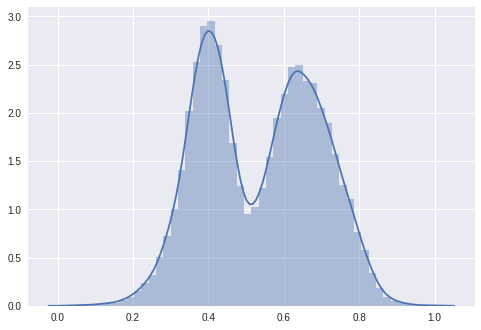

In [291]:
sns.distplot(y);

In [292]:
kde = gaussian_kde(y)

In [293]:
#probs = kde.evaluate(y)

## Build estimator for age, education, weekly income, child number, household number

In [300]:
# Polynominal features for age
agetrans = Pipeline([
    ('featse0', DataFrameSelector(feature_names=['TEAGE'], dtype=float)),
    ('scaler0', StandardScaler()),
    ('polyno0', PolynomialFeatures(degree=3, include_bias=True)),
])

# Location features
loctrans = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['LONGITUDE', 'LATITUDE'], dtype=float)),
    ('impute1', Imputer(missing_values='NaN', strategy='median', axis=0)),
])

# Education level feature
edutrans = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['PEEDUCA'], dtype=float)),
    ('impute2', Imputer(missing_values='NaN', strategy='median', axis=0)),
    ('scaler2', StandardScaler()),
    ('polyno2', PolynomialFeatures(degree=2, include_bias=False)),
])

# Weekly earnings feature
weatrans = Pipeline([
    ('featse3', DataFrameSelector(feature_names=['TRERNWA'], dtype=float)),
    ('impute3', ImputeNumber()),
    ('scaler3', StandardScaler()),
    ('polyno3', PolynomialFeatures(degree=2, include_bias=False)),
])

# Number of children/household features
lintrans = Pipeline([
    ('featse4', DataFrameSelector(feature_names=['TRCHILDNUM', 'TRNUMHOU'], dtype=float)),
    ('impute4', ImputeNumber()),
])

est = Pipeline([
    ('union01', FeatureUnion([
        ('agetran', agetrans),
        ('loctran', loctrans),        
        ('edutran', edutrans),
        ('weatran', weatrans),
        ('lintran', lintrans)
    ])),
    ('scaler', StandardScaler()),
    ('ransac', RANSACRegressor(base_estimator=Ridge(alpha=12.0),
                               random_state=42,
                               residual_threshold=0.15))    
])

In [295]:
# Grid search CV
ta = [0.05, 0.1, 0.5, 1, 2, 5, 7.5, 10, 12, 15, 17.5, 20, 25, 30]
gridsearch1 = GridSearchCV(est,
                          {'ransac__base_estimator__alpha': ta
                          },
                          cv=7,
                          n_jobs=-2,
                          scoring='neg_mean_squared_error',
                          verbose=True)

In [296]:
gridsearch1.fit(X, y)

Fitting 7 folds for each of 14 candidates, totalling 98 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-2)]: Done  98 out of  98 | elapsed:   34.5s finished


GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse0', DataFrameSelector(dtype=<type 'float'>, feature_names=['TEAGE'], ntn=False)), ('scaler0', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polyno0', PolynomialFeat...=None, residual_threshold=0.15, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'ransac__base_estimator__alpha': [0.05, 0.1, 0.5, 1, 2, 5, 7.5, 10, 12, 15, 17.5, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [297]:
opt_alpha = gridsearch1.best_params_['ransac__base_estimator__alpha']
opt_alpha

12

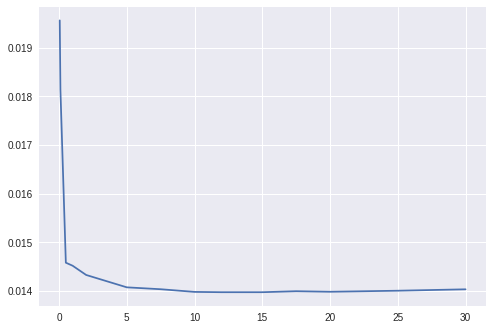

In [298]:
# Graphs
plt.plot(ta, -gridsearch1.cv_results_['mean_test_score']);

### Fitting using the best parameters on training set for a specific metric

In [301]:
est.fit(X, y)

Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse0', DataFrameSelector(dtype=<type 'float'>, feature_names=['TEAGE'], ntn=False)), ('scaler0', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polyno0', PolynomialFeat...=None, residual_threshold=0.15, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf))])

In [302]:
# Pickle model
joblib.dump(est, 'models/pred_model_atus_est_{}_{}.pkl'.format(m, date.today()))

['models/pred_model_atus_est_metric1_2017-11-07.pkl']

In [303]:
est.score(X, y)

0.41068058186094547

In [304]:
compute_mse(est, X, y, 3)

0.014020665818411207

In [305]:
est.predict(X.head(25))

array([ 0.51492852,  0.35517883,  0.4917009 ,  0.47609219,  0.57163537,
        0.40423899,  0.50819312,  0.72684574,  0.59846818,  0.69225621,
        0.54953434,  0.62318206,  0.59773603,  0.61908274,  0.37068988,
        0.38746778,  0.58309056,  0.56390885,  0.38392531,  0.51923496,
        0.63434498,  0.44441698,  0.58051671,  0.60222227,  0.69146232])

In [306]:
y[:25]

array([ 0.63419014,  0.30352113,  0.31919014,  0.39415493,  0.35      ,
        0.41725352,  0.35211268,  0.71197183,  0.63257042,  0.83309859,
        0.57852113,  0.64788732,  0.68028169,  0.82633803,  0.25757042,
        0.46091549,  0.59964789,  0.6709507 ,  0.34665493,  0.7443662 ,
        0.82728873,  0.38802817,  0.64647887,  0.61232394,  0.69366197])

In [307]:
compute_mse(est, X_test, y_test, 3)

0.013851670004822023

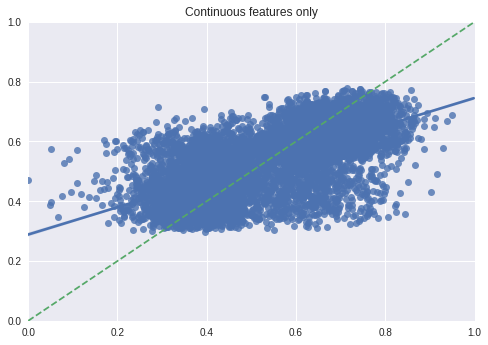

In [308]:
sns.regplot(y_test, est.predict(X_test))
plt.plot([0, 1], [0, 1], ls='--')
plt.axis([0, 1, 0, 1])
plt.title("Continuous features only");

## Build estimator for all categorical features

In [309]:
# Use label encoding (to prevent large feature spaces)
catlarge = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['PTDTRACE',
                                                 'TRDTOCC1'], dtype=np.float64, ntn=True)),
    ('sscale1', StandardScaler()),
])

# Use one-hot-encoding followed by truncated SVD to reduce feature count
catsmall = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['GEMETSTA',
                                                 'TELFS',
                                                 'TRDPFTPT',
                                                 'TRSPPRES',
                                                 'TESCHENR',
                                                 'TEIO1COW'], dtype=np.int64, ntn=True)),
    ('oencode', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('sscale2', StandardScaler()),
    ('pcaana2', PCA(n_components=10, random_state=42)),
])

est_cat = Pipeline([
    ('union01', FeatureUnion([
        ('clarge', catlarge),
        ('csmall', catsmall)
    ])),
    ('erfregr', ExtraTreesRegressor(n_estimators=150,
                                    max_depth=10,
                                    min_samples_leaf=1,
                                    random_state=42))
])

In [310]:
# Grid search CV
tmd = [4, 6, 8, 10, 12, 15]
gridsearch_cat = GridSearchCV(est_cat,
                              {'erfregr__max_depth': tmd
                              },
                              cv=3,
                              n_jobs=-2,
                              scoring='neg_mean_squared_error',
                              verbose=True)

In [311]:
gridsearch_cat.fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-2)]: Done  18 out of  18 | elapsed:   31.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('clarge', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.float64'>,
         feature_names=['PTDTRACE', 'TRDTOCC1'], ntn=True)), ('sscale1', StandardScaler(copy=True, with_mean=True, with_std=True...estimators=150, n_jobs=1,
          oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'erfregr__max_depth': [4, 6, 8, 10, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [312]:
gridsearch_cat.best_params_

{'erfregr__max_depth': 10}

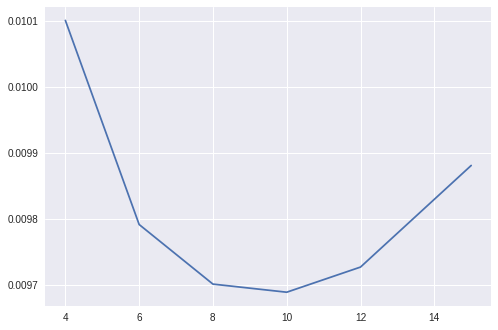

In [313]:
plt.plot(tmd, -gridsearch_cat.cv_results_['mean_test_score']);

### Fitting using the best parameters on training set for a specific metric

In [314]:
est_cat.fit(X, y)

Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('clarge', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.float64'>,
         feature_names=['PTDTRACE', 'TRDTOCC1'], ntn=True)), ('sscale1', StandardScaler(copy=True, with_mean=True, with_std=True...estimators=150, n_jobs=1,
          oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [315]:
# Pickle model
joblib.dump(est_cat, 'models/pred_model_atus_catest_{}_{}.pkl'.format(m, date.today()))

['models/pred_model_atus_catest_metric1_2017-11-07.pkl']

In [316]:
est_cat.score(X, y)

0.60656910678493747

In [317]:
compute_mse(est_cat, X, y, 3)

0.0096883520796689979

In [318]:
est_cat.predict(X.head(15))

array([ 0.41530552,  0.43073831,  0.43177724,  0.43472718,  0.42200032,
        0.38837557,  0.38837557,  0.69063592,  0.63228195,  0.70395509,
        0.43209699,  0.53424642,  0.41495334,  0.62351736,  0.38837557])

In [319]:
y[:15]

array([ 0.63419014,  0.30352113,  0.31919014,  0.39415493,  0.35      ,
        0.41725352,  0.35211268,  0.71197183,  0.63257042,  0.83309859,
        0.57852113,  0.64788732,  0.68028169,  0.82633803,  0.25757042])

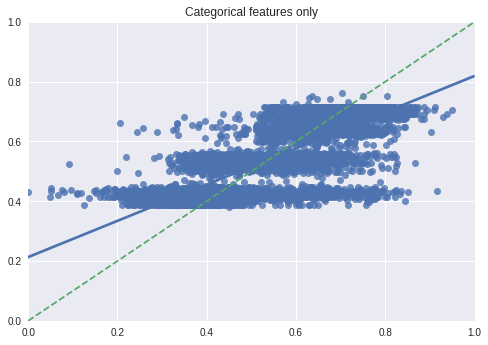

In [320]:
sns.regplot(y_test, est_cat.predict(X_test))
plt.plot([0,1], [0,1], ls='--')
plt.axis([0, 1, 0, 1])
plt.title("Categorical features only");

## Combined model that uses both continuous and categorical models

In [321]:
full_est = Pipeline([
    ('union', FeatureUnion([
        ('conest', EstimatorTransformer(est)),
        ('catest', EstimatorTransformer(est_cat))
    ])),
    ('quadrat', PolynomialFeatures(degree=2, include_bias=True)),
    ('combi', LinearRegression())
])

In [322]:
full_est.fit(X, y)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('conest', EstimatorTransformer(estimator=Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('agetran', Pipeline(memory=None,
     steps=[('featse0', DataFrameSelector(dtype=<type 'float'>, f...ly=False)), ('combi', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [323]:
# Pickle model
joblib.dump(full_est, 'models/pred_model_atus_FULLEST_{}_{}_{}.pkl'.format(dt, m, date.today()))

['models/pred_model_atus_FULLEST_weday_metric1_2017-11-07.pkl']

In [324]:
full_est.score(X, y)

0.60832795606860479

In [325]:
compute_mse(full_est, X, y, 3)

0.0096256990865549192

In [326]:
full_est.predict(X.head(15))

array([ 0.41832164,  0.42250653,  0.43308092,  0.43473831,  0.43103644,
        0.38147198,  0.38967061,  0.70213339,  0.63460436,  0.70815228,
        0.43898694,  0.54792248,  0.42676816,  0.62933509,  0.37946205])

In [327]:
y[:15]

array([ 0.63419014,  0.30352113,  0.31919014,  0.39415493,  0.35      ,
        0.41725352,  0.35211268,  0.71197183,  0.63257042,  0.83309859,
        0.57852113,  0.64788732,  0.68028169,  0.82633803,  0.25757042])

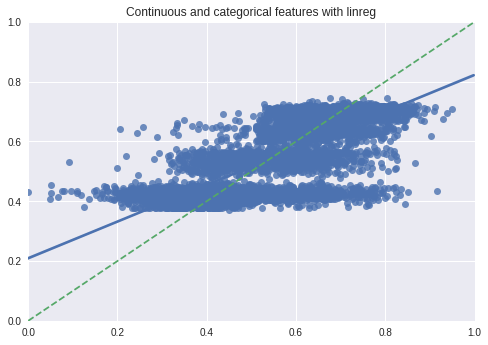

In [328]:
sns.regplot(y_test, full_est.predict(X_test))
plt.plot([0,1], [0,1], ls='--')
plt.axis([0, 1, 0, 1])
plt.title("Continuous and categorical features with linreg");

## Combined model that uses the same estimator (testing only)

In [134]:
# Polynominal features for age
agetrans = Pipeline([
    ('featse0', DataFrameSelector(feature_names=['TEAGE'], dtype=float)),
    ('scaler0', StandardScaler()),
    ('polyno0', PolynomialFeatures(degree=3, include_bias=True)),
])

# Location features
loctrans = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['LONGITUDE', 'LATITUDE'], dtype=float)),
    ('impute1', Imputer(missing_values='NaN', strategy='median', axis=0)),
])

# Education level feature
edutrans = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['PEEDUCA'], dtype=float)),
    ('impute2', Imputer(missing_values='NaN', strategy='median', axis=0)),
    ('scaler2', StandardScaler()),
    ('polyno2', PolynomialFeatures(degree=2, include_bias=False)),
])

# Weekly earnings feature
weatrans = Pipeline([
    ('featse3', DataFrameSelector(feature_names=['TRERNWA'], dtype=float)),
    ('impute3', ImputeNumber()),
    ('scaler3', StandardScaler()),
    ('polyno3', PolynomialFeatures(degree=2, include_bias=False)),
])

# Number of children/household features
lintrans = Pipeline([
    ('featse4', DataFrameSelector(feature_names=['TRCHILDNUM', 'TRNUMHOU'], dtype=float)),
    ('impute4', ImputeNumber()),
])

# Use label encoding (to prevent large feature spaces)
catlarge = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['PTDTRACE',
                                                 'TRDTOCC1'], dtype=np.float64, ntn=True)),
    ('sscale1', StandardScaler()),
])

# Use one-hot-encoding followed by truncated SVD to reduce feature count
catsmall = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['GEMETSTA',
                                                 'TELFS',
                                                 'TRDPFTPT',
                                                 'TRSPPRES',
                                                 'TESCHENR',
                                                 'TEIO1COW'], dtype=np.int64, ntn=True)),
    ('oencode', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('sscale2', StandardScaler()),
    ('pcaana2', PCA(n_components=10, random_state=42)),
])

# Full estimator
full_est_new = Pipeline([
    ('union', FeatureUnion([
        ('catl', catlarge),
        ('cats', catsmall),
        ('agetran', agetrans),
        ('loctran', loctrans),
        ('edutran', edutrans),
        ('weatran', weatrans),
        ('lintran', lintrans),
    ])),
    ('erfregr', ExtraTreesRegressor(n_estimators=150,
                                    max_depth=10,
                                    min_samples_leaf=1,
                                    random_state=42,
                                    n_jobs=-2))
])

In [135]:
full_est_new.fit(X, y)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('catl', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.float64'>,
         feature_names=['PTDTRACE', 'TRDTOCC1'], ntn=True)), ('sscale1', StandardScaler(copy=True, with_mean=True, with_std=True))])...stimators=150, n_jobs=-2,
          oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [136]:
# Pickle model
joblib.dump(full_est_new, 'models/pred_model_atus_fullestnew_{}_{}.pkl'.format(m, date.today()))

['models/pred_model_atus_fullestnew_metric1_2017-11-07.pkl']

In [137]:
full_est_new.score(X, y)

0.62821177498890601

In [139]:
0.0094489632174263975

0.009448963217426398

In [140]:
compute_mse(full_est_new, X, y, 3)

0.0094384590370202026

In [141]:
full_est_new.predict(X.head(15))

array([ 0.43608494,  0.41029812,  0.43878742,  0.4300989 ,  0.41864252,
        0.41452279,  0.4143882 ,  0.70405328,  0.63619124,  0.72134288,
        0.44108437,  0.56280952,  0.40657033,  0.64248541,  0.39607806])

In [142]:
y[:15]

array([ 0.63419014,  0.30352113,  0.31919014,  0.39415493,  0.35      ,
        0.41725352,  0.35211268,  0.71197183,  0.63257042,  0.83309859,
        0.57852113,  0.64788732,  0.68028169,  0.82633803,  0.25757042])

In [143]:
compute_mse(full_est_new, X_test, y_test, 3)

0.0092749661347490669

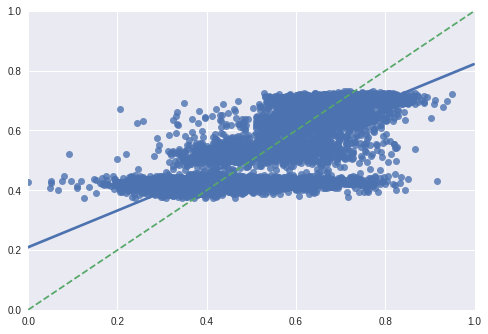

In [144]:
sns.regplot(y_test, full_est_new.predict(X_test))
plt.axis([0, 1, 0, 1])
plt.plot([0,1], [0,1], ls='--');